In [1]:
#ML final project
#Yu Zhou, Che Wang

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
import numpy as np
import keras
from keras import backend as K
import matplotlib.image as mpimg
from glob import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# A bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import misc
"""datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')"""
#don't worry about data augmentation for now...
#data preprocessing is done in another file
print()

Using TensorFlow backend.


In [2]:

globPaths = ['data/c0small/*.jpg','data/c1small/*.jpg','data/c2small/*.jpg','data/c3small/*.jpg','data/c4small/*.jpg',
            'data/c5small/*.jpg','data/c6small/*.jpg','data/c7small/*.jpg',
            'data/c8small/*.jpg','data/c9small/*.jpg']
num_classes = 10
numTrain = 1500

X_train = np.empty((15000,64,64,3))
X_test = np.empty((4000,64,64,3))
y_train = np.empty((15000))
y_test = np.empty((4000))

i = 0
j = 0

for folderIndex in range(10):
    index = 0
    filelist = glob(globPaths[folderIndex])
    for filename in filelist:
        newImg = misc.imread(filename)
        if index<numTrain:
            X_train[i] = newImg
            y_train[i] = folderIndex
            i+=1
        else:
            X_test[j] = newImg
            y_test[j] = folderIndex
            j+=1
        index+=1
        if index%200==0:
            print("reading img,",folderIndex,index)
        
        
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#then data normalization
X_train /= 255
X_test /= 255

print("y_train",y_train.shape[0])
print("y_test",y_test.shape[0])

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)
print("data read and normalization finished!")



reading img, 0 200
reading img, 0 400
reading img, 0 600
reading img, 0 800
reading img, 0 1000
reading img, 0 1200
reading img, 0 1400
reading img, 0 1600
reading img, 0 1800
reading img, 1 200
reading img, 1 400
reading img, 1 600
reading img, 1 800
reading img, 1 1000
reading img, 1 1200
reading img, 1 1400
reading img, 1 1600
reading img, 1 1800
reading img, 2 200
reading img, 2 400
reading img, 2 600
reading img, 2 800
reading img, 2 1000
reading img, 2 1200
reading img, 2 1400
reading img, 2 1600
reading img, 2 1800
reading img, 3 200
reading img, 3 400
reading img, 3 600
reading img, 3 800
reading img, 3 1000
reading img, 3 1200
reading img, 3 1400
reading img, 3 1600
reading img, 3 1800
reading img, 4 200
reading img, 4 400
reading img, 4 600
reading img, 4 800
reading img, 4 1000
reading img, 4 1200
reading img, 4 1400
reading img, 4 1600
reading img, 4 1800
reading img, 5 200
reading img, 5 400
reading img, 5 600
reading img, 5 800
reading img, 5 1000
reading img, 5 1200
read

In [3]:
#here we can save x and y as numpy files so it's easier to use them again
#np.save("X_train.npy",X_train)
#np.save("X_test.npy",X_test)
#np.save("Y_train.npy",Y_train)
#np.save("Y_test.npy",Y_test)
#print("Successfully save data to numpy files!")

In [4]:
# input image dimensions
img_rows, img_cols = 64, 64
img_channels = 3
#the later are about training...

input_shape = (img_rows, img_cols, img_channels)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),padding= 'same',
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt, #keras.optimizers.Adadelta(0.01),
              metrics=['accuracy'])
print("model building and compiling finished!")


model building and compiling finished!


In [5]:
#from keras.utils import plot_model
#plot the model as png
#plot_model(model, to_file='model.png',show_shapes=True)

In [6]:
def writeHistoryToFile(his,filename):
    hisFile = open(filename, "w")
    hisFile.write("epoch acc val_acc loss val_loss\n")
    hisData = his.history
    acc = hisData['acc']
    loss = hisData['loss']
    val_acc = hisData['val_acc']
    val_loss = hisData['val_loss']
    n = len(acc)
    print(n)
    for i in range(n):
        ss = " ".join([str(i),str(acc[i]),str(val_acc[i]),str(loss[i]),str(val_loss[i]),"\n"])
        hisFile.write(ss)


In [7]:
batch_size = 32 
nb_training_stages = 4 #at the end of each stage, we save the model
nb_epoch = 10
RESUME = False
resume_filepath = 'keras_cnn_model.h5'
if RESUME:
    print('model resumed! filepath: '+resume_filepath)
    model = keras.models.load_model(resume_filepath)

    
HISTORYTEST = False
if HISTORYTEST:
    X_train = X_train[:32,:]
    Y_train = Y_train[:32,:]
    X_test = X_test[:32,:]
    Y_test = Y_test[:32,:]
    nb_training_stages = 1


#score = model.evaluate(X_test[:150], Y_test[:150], verbose=0)
#print('Original test loss estimate:', score[0])
#print('Original test accuracy estimate:', score[1])
history = {} #all the history will be stored here
for stage in range(nb_training_stages):
    history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=1,
          validation_data=(X_test, Y_test))
    historyFileName = "history_trace_"+str(stage)+".txt"
    writeHistoryToFile(history,historyFileName)

    pred = model.predict(X_train,batch_size=10)
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    saveName = 'keras_cnn_model_'+str(stage)+'.h5'
    model.save(saveName)


Train on 15000 samples, validate on 4000 samples
Epoch 1/10
15000/15000 [==============================] - 629s - loss: 1.4758 - acc: 0.4787 - val_loss: 0.5420 - val_acc: 0.8420
Epoch 2/10
15000/15000 [==============================] - 620s - loss: 0.6997 - acc: 0.7777 - val_loss: 0.2767 - val_acc: 0.9225
Epoch 3/10
15000/15000 [==============================] - 542s - loss: 0.5149 - acc: 0.8484 - val_loss: 0.2059 - val_acc: 0.9427
Epoch 4/10
15000/15000 [==============================] - 599s - loss: 0.5148 - acc: 0.8674 - val_loss: 0.1739 - val_acc: 0.9565
Epoch 5/10
15000/15000 [==============================] - 559s - loss: 0.4597 - acc: 0.8839 - val_loss: 0.2107 - val_acc: 0.9483
Epoch 6/10
15000/15000 [==============================] - 517s - loss: 0.4805 - acc: 0.8861 - val_loss: 0.1540 - val_acc: 0.9630
Epoch 7/10
15000/15000 [==============================] - 499s - loss: 0.4513 - acc: 0.8912 - val_loss: 0.1812 - val_acc: 0.9650
Epoch 8/10
15000/15000 [========================

KeyboardInterrupt: 

In [8]:
#function for single image last layer probability print out
#return a list of index and a list of probability values


def softMax(pred,index):
    denominator = 0
    for i in range(10):
        denominator+=np.exp(pred[i])
    result = np.exp(pred[index])/denominator
    return np.exp(pred[index])/denominator


def showImagePred(model, X_test, index):
    imageData = np.reshape(X_test[index,:],(64,64,3))
    plt.title(str(index))
    plt.imshow(imageData)
    plt.show()
    pred = model.predict(X_test[index:index+1])[0]
    sortedIndexes = np.argsort(pred)
    for i in range(-1,-4,-1):
        predIndex = sortedIndexes[i]
        ss = classification(predIndex) +": "+"{0:.2f}".format(softMax(pred,predIndex))
        print(ss)
    
#a function that returns the classification with the input of index
def classification(class_index):
    classNames = ["safe driving","texting - right","talking on the phone - right",
                  "texting - left","talking on the phone - left","operating the radio",
                  "drinking","reaching behind","hair and makeup","talking to passenger"]
    return classNames[class_index]



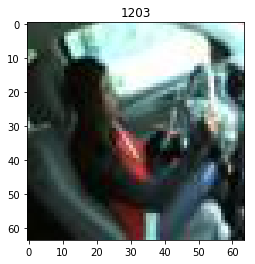

texting - left: 0.23
safe driving: 0.09
talking to passenger: 0.09


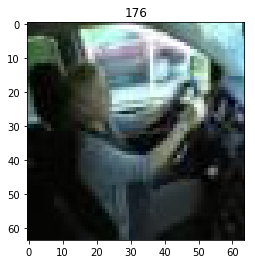

safe driving: 0.23
talking to passenger: 0.09
texting - left: 0.09


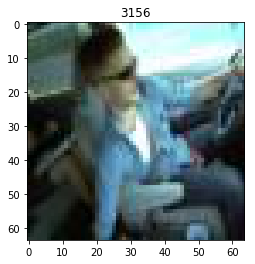

reaching behind: 0.23
hair and makeup: 0.09
talking on the phone - right: 0.09


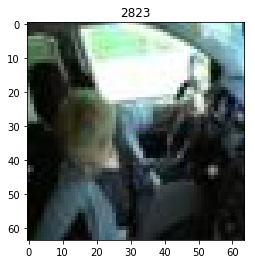

reaching behind: 0.23
hair and makeup: 0.09
talking to passenger: 0.09


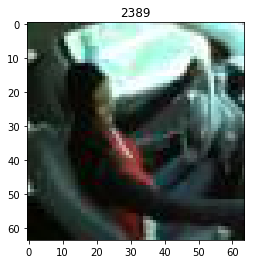

operating the radio: 0.23
talking to passenger: 0.09
safe driving: 0.09


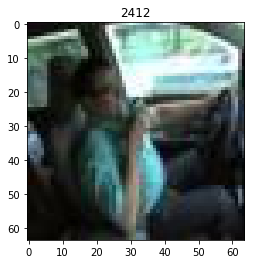

drinking: 0.23
talking on the phone - right: 0.09
talking to passenger: 0.09


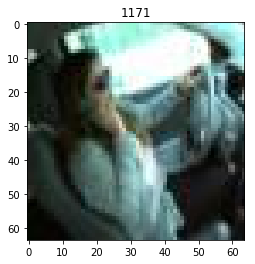

talking on the phone - right: 0.23
safe driving: 0.09
talking to passenger: 0.09


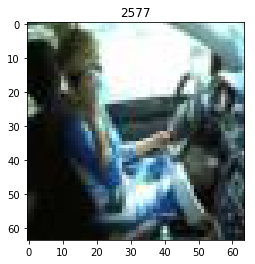

drinking: 0.22
talking to passenger: 0.09
hair and makeup: 0.09


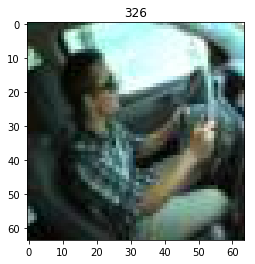

safe driving: 0.23
texting - left: 0.09
talking to passenger: 0.09


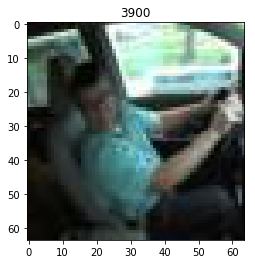

talking to passenger: 0.23
safe driving: 0.09
hair and makeup: 0.09


In [10]:
for i in range(10):
    rr = np.random.randint(4000)
    showImagePred(model,X_test,rr)
